In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

# Exercises

#### 1. How many different cases are there, by department?

In [17]:
df.groupBy('department', 'case_status').count().sort("department", "case_status").show(truncate = False)

+------------------------+-----------+------+
|department              |case_status|count |
+------------------------+-----------+------+
|Animal Care Services    |Closed     |116446|
|Animal Care Services    |Open       |469   |
|City Council            |Closed     |4     |
|City Council            |Open       |29    |
|Customer Service        |Closed     |1684  |
|Customer Service        |Open       |1165  |
|DSD/Code Enforcement    |Closed     |309239|
|DSD/Code Enforcement    |Open       |12135 |
|Metro Health            |Closed     |5088  |
|Metro Health            |Open       |75    |
|Parks & Recreation      |Closed     |19511 |
|Parks & Recreation      |Open       |396   |
|Solid Waste             |Closed     |277660|
|Solid Waste             |Open       |1610  |
|Trans & Cap Improvements|Closed     |93962 |
|Trans & Cap Improvements|Open       |2231  |
+------------------------+-----------+------+



In [16]:
df.groupBy('department').count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



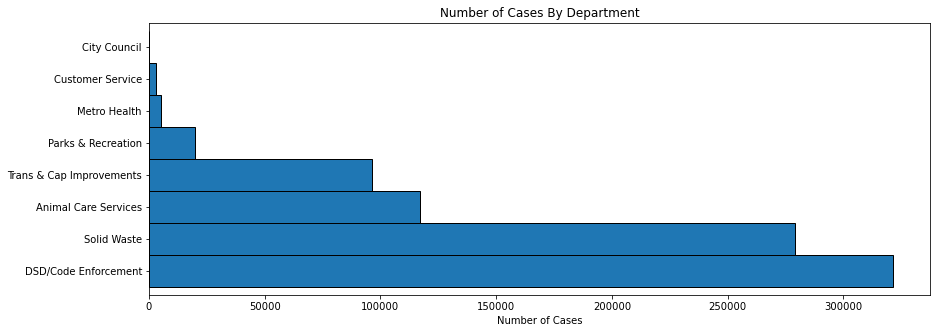

In [10]:
# Example from lesson:

# First aggregate with spark
(
    df.groupBy("department")
    .count()
    # then pass to pandas
    .toPandas()
    .set_index("department")["count"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")
plt.show()

#### 2. Does the percentage of cases that are late vary by department?

In [120]:
# Creating a dataframe grouped by department of *only* late cases:

case_late_df = df.filter(expr("case_late == true")).groupBy("department").count()
print("Original Dataframe \n------------------\n")
case_late_df.show(truncate = False)
# df.filter(expr("case_late == true")).count()

# Now getting the count of all late cases (my denominator).

count_late = df.filter(expr("case_late == true")).count()

# Creating a column that divides each department total by the overall total, or the percentage of late cases:

late_df = case_late_df.withColumn('percentage', round(case_late_df['count'] / float(count_late), 2))

# Final df in Spark:
print("\n Final Dataframe \n-----------------\n")
late_df.show(truncate = False)

Original Dataframe 
------------------

+------------------------+-----+
|department              |count|
+------------------------+-----+
|Solid Waste             |32945|
|Animal Care Services    |23276|
|Trans & Cap Improvements|5411 |
|Parks & Recreation      |3797 |
|Customer Service        |2010 |
|Metro Health            |829  |
|DSD/Code Enforcement    |26235|
+------------------------+-----+


 Final Dataframe 
-----------------

+------------------------+-----+----------+
|department              |count|percentage|
+------------------------+-----+----------+
|Solid Waste             |32945|0.35      |
|Animal Care Services    |23276|0.25      |
|Trans & Cap Improvements|5411 |0.06      |
|Parks & Recreation      |3797 |0.04      |
|Customer Service        |2010 |0.02      |
|Metro Health            |829  |0.01      |
|DSD/Code Enforcement    |26235|0.28      |
+------------------------+-----+----------+



#### Takeaway:
- Yes, the percentage of late cases varies *dramatically* by department.

#### 3. On average, how late are the late cases by department?

In [113]:
df.filter(df.case_late == True).count()

94503

In [114]:
df.filter(df.case_late == True).groupBy("department").agg((mean(df.num_days_late)).alias("mean_late")).show()

+--------------------+------------------+
|          department|         mean_late|
+--------------------+------------------+
|         Solid Waste| 7.186821906120899|
|Animal Care Services|23.458633245820124|
|Trans & Cap Impro...|10.603064680316946|
|  Parks & Recreation|22.348910457867518|
|    Customer Service| 87.68385942150394|
|        Metro Health|6.5438133155476494|
|DSD/Code Enforcement| 49.38428705358908|
+--------------------+------------------+



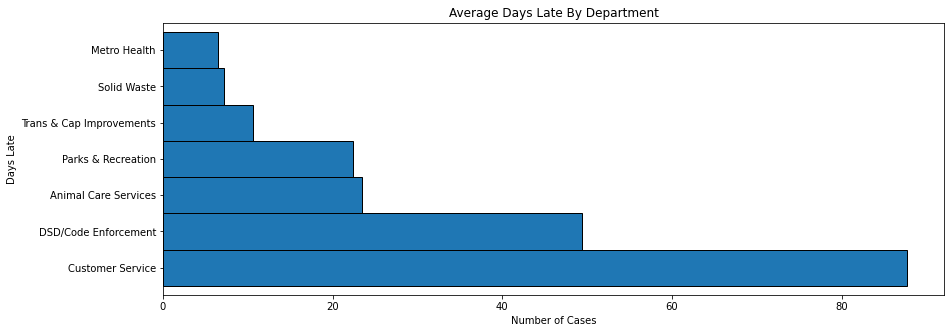

In [115]:
# Moving to python for visualization
(
    df.filter(df.case_late == True)
    .groupBy("department")
    .agg((mean(df.num_days_late)).alias("mean_late"))
    # then pass to pandas
    .toPandas()
    .set_index("department")["mean_late"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.title("Average Days Late By Department")
plt.ylabel("Days Late")
plt.xlabel("Number of Cases")
plt.show()

#### 4. What is the service type that is the most late? Just for Parks & Rec?

In [118]:
df.printSchema(), df.show(1, vertical = True)

root
 |-- case_id: integer (nullable = true)
 |-- case_opened_date: timestamp (nullable = true)
 |-- case_closed_date: timestamp (nullable = true)
 |-- case_due_date: timestamp (nullable = true)
 |-- case_late: boolean (nullable = true)
 |-- num_days_late: double (nullable = true)
 |-- case_closed: boolean (nullable = true)
 |-- service_request_type: string (nullable = true)
 |-- SLA_days: double (nullable = true)
 |-- case_status: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: string (nullable = false)
 |-- num_weeks_late: double (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- case_age: integer (nullable = true)
 |-- days_to_closed: integer (nullable = true)
 |-- case_lifetime: integer (nullable = true)
 |-- department: string (nullable = true)
 |-- dept_subject_to_SLA: boolean (nullable = true)

-RECORD 0------------------------------------
 case_id              | 1014127332        

(None, None)

In [130]:
# service type that is most late overall: 

(
    df.filter(df.case_late == True)
    .groupBy("service_request_type")
    .agg(mean(df.num_days_late).alias("avg_days_late"))
    .sort(desc("avg_days_late")).show(5)
)



+--------------------+------------------+
|service_request_type|     avg_days_late|
+--------------------+------------------+
|Zoning: Recycle Yard|210.89201994318182|
|  Zoning: Junk Yards|200.20517608494276|
|Structure/Housing...|190.20707698509807|
|Donation Containe...|171.09115313942615|
|Storage of Used M...|163.96812829714287|
+--------------------+------------------+
only showing top 5 rows



In [123]:
L = ['apples', 'bananas', 'oranges']
for idx, val in enumerate(L):
    print("index is %d and value is %s" % (idx, val))

index is 0 and value is apples
index is 1 and value is bananas
index is 2 and value is oranges
